In [1]:
from airplane import Airplane
from receiver import Receiver

airplane1 = Airplane('782034',[120.128234,30.2141348,10000],[115.86143245,28.750012,10000],180,3340)
receiver1 = Receiver([114.122588,36.548925,1000])
time_track1 =receiver1.fin_time_track(airplane1)
track1 = airplane1.track

6472 6472


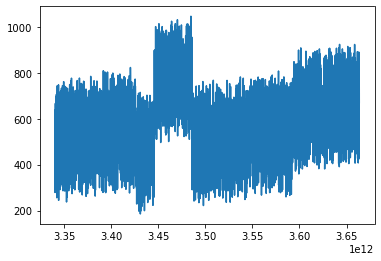

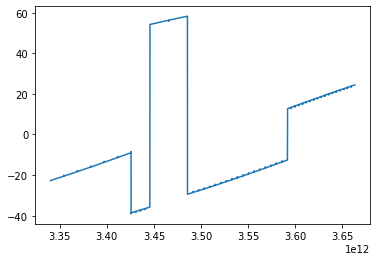

In [3]:
# 获取前后数据包时间差
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt,pi, atan

using_data = time_track1
time_error = []
location_error = []
print(len(track1),len(using_data))

for i in range(len(using_data)-1):
    time_error.append(using_data[i+1]-using_data[i]-50000000)#-(airplane1.geodistance(track1[i+1],receiver1.location)-airplane1.geodistance(track1[i],receiver1.location))*10/3)
    location_error.append(airplane1.geodistance(track1[i+1],receiver1.location)-airplane1.geodistance(track1[i],receiver1.location))
    
# plt.plot(using_data[19:79], test_data[19:79])
plt.plot(using_data[:-1], time_error)
plt.show()
# plt.ylim(0.39,0.6)
# plt.xlim(0.39,0.6)
plt.plot(using_data[:-1], location_error)
plt.show()


In [5]:
# 划分训练集和测试集
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

x_data = torch.tensor(time_error)
y_data = torch.tensor(location_error)
print(x_data)
print(y_data)

test_size = 1000

x_train_set = time_error[: -test_size]
x_test_set = time_error[-test_size:]

y_train_set = location_error[: -test_size]
y_test_set = location_error[-test_size:]


tensor([597.8530, 313.0815, 637.5156,  ..., 873.4819, 782.0225, 671.1929])
tensor([-22.7009, -22.6939, -22.6849,  ...,  24.4127,  24.4217,  24.4287])


In [6]:
# 训练集数据归一化，并化为cuda类型
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(-1,1))

x_train_set_array = np.array(x_train_set)
x_train_norm = sc.fit_transform(x_train_set_array.reshape(-1,1))
x_train_norm = torch.FloatTensor(x_train_norm).view(-1).cuda()

y_train_set_array = np.array(y_train_set)
y_train_norm = sc.fit_transform(y_train_set_array.reshape(-1,1))
y_train_norm = torch.FloatTensor(y_train_norm).view(-1).cuda()

# train_set_array = np.array(train_set)
# train_norm = sc.fit_transform(train_set_array.reshape(-1,1))
# train_norm = torch.FloatTensor(train_norm).view(-1).cuda()


In [7]:
print(x_train_norm)

tensor([-0.0424, -0.7033,  0.0496,  ...,  0.5233,  0.4592, -0.2462],
       device='cuda:0')


In [10]:
lenth = len(x_train_norm)
train_data = []
for i in range(lenth):
    train_data.append((x_train_norm[i:i+1],y_train_norm[i:i+1]))

print(train_data[0:10])

[(tensor([-0.0424], device='cuda:0'), tensor([-0.6624], device='cuda:0')), (tensor([-0.7033], device='cuda:0'), tensor([-0.6623], device='cuda:0')), (tensor([0.0496], device='cuda:0'), tensor([-0.6621], device='cuda:0')), (tensor([-0.7830], device='cuda:0'), tensor([-0.6619], device='cuda:0')), (tensor([-0.1962], device='cuda:0'), tensor([-0.6618], device='cuda:0')), (tensor([-0.2274], device='cuda:0'), tensor([-0.6616], device='cuda:0')), (tensor([-0.0080], device='cuda:0'), tensor([-0.6615], device='cuda:0')), (tensor([-0.2000], device='cuda:0'), tensor([-0.6613], device='cuda:0')), (tensor([-0.5554], device='cuda:0'), tensor([-0.6612], device='cuda:0')), (tensor([-0.2497], device='cuda:0'), tensor([-0.6610], device='cuda:0'))]


In [11]:
print(train_data[0][1])

tensor([-0.6624], device='cuda:0')


In [13]:
# lstm模型
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50,out_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size,out_size)
        self.hidden = ( torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1, -1), self.hidden)
        pred= self.linear(lstm_out.view(len(seq), -1))

        return pred[-1]


torch.manual_seed(42)
model = LSTM().cuda()
# train_data.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)


print(model)


for p in model.parameters():
    print(p.numel())

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)
200
10000
200
200
50
1


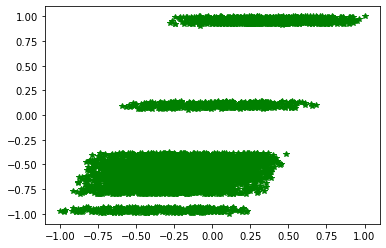

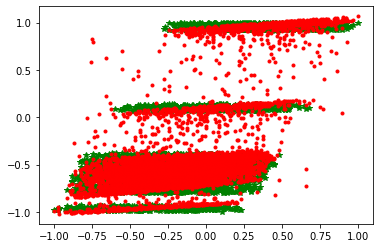

 Epoch 0 Loss:  0.002382498700171709


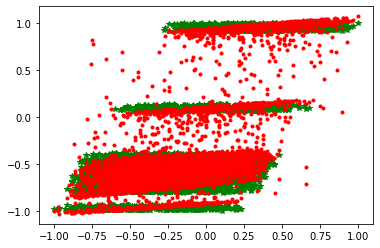

 Epoch 1 Loss:  0.0026386037934571505


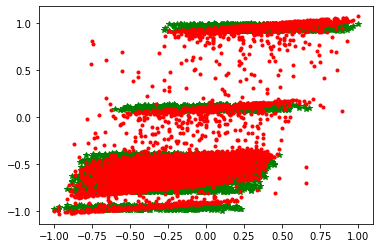

 Epoch 2 Loss:  0.0027639747131615877


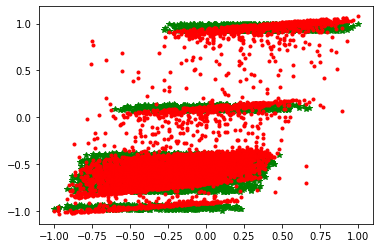

 Epoch 3 Loss:  0.0028187844436615705


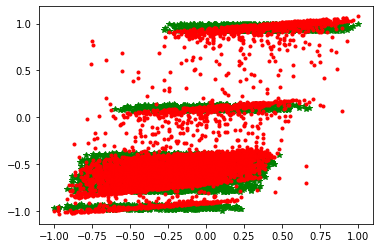

 Epoch 4 Loss:  0.0028382467571645975


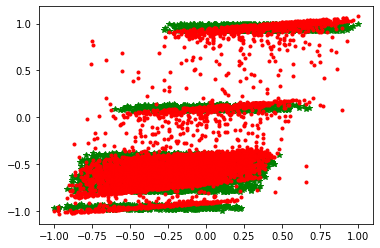

 Epoch 5 Loss:  0.0028405748307704926


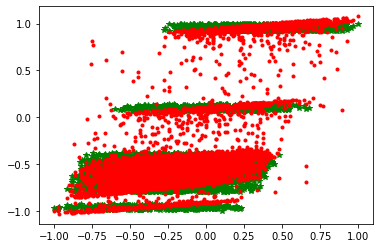

 Epoch 6 Loss:  0.002834700047969818


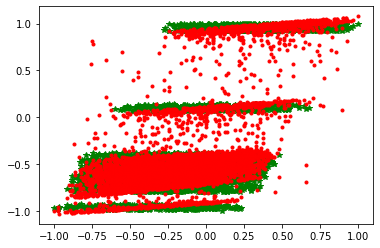

 Epoch 7 Loss:  0.0028249602764844894


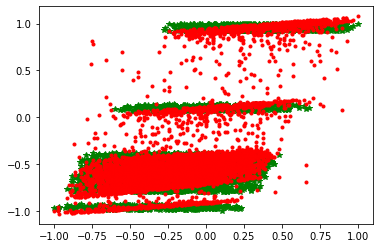

 Epoch 8 Loss:  0.002813466591760516


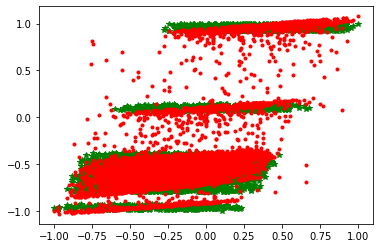

 Epoch 9 Loss:  0.0028012627735733986


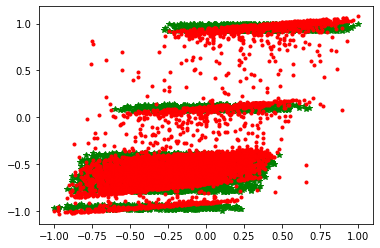

 Epoch 10 Loss:  0.0027888817712664604


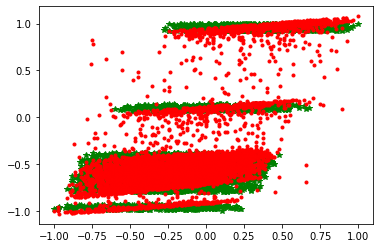

 Epoch 11 Loss:  0.002776612062007189


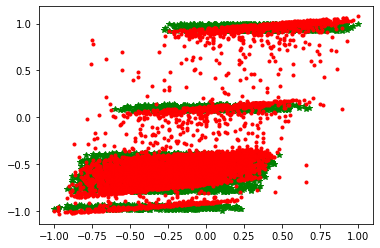

 Epoch 12 Loss:  0.0027646280359476805


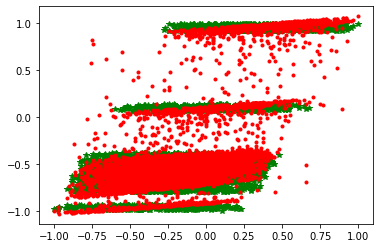

 Epoch 13 Loss:  0.002753028878942132


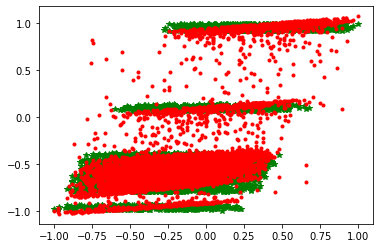

 Epoch 14 Loss:  0.0027418986428529024


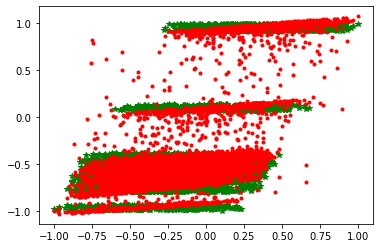

 Epoch 15 Loss:  0.002731301821768284


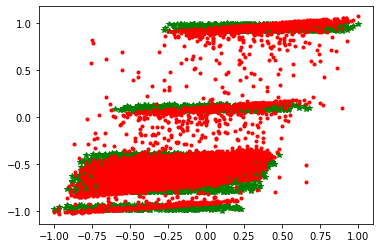

 Epoch 16 Loss:  0.0027212821878492832


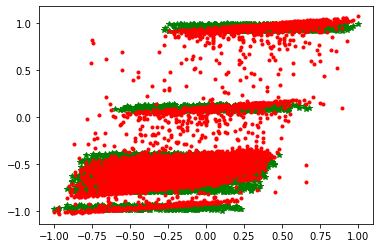

 Epoch 17 Loss:  0.0027118660509586334


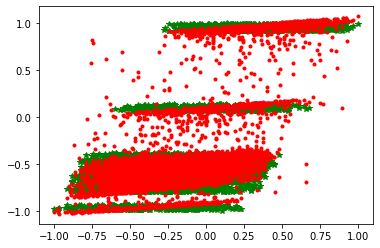

 Epoch 18 Loss:  0.0027030734345316887


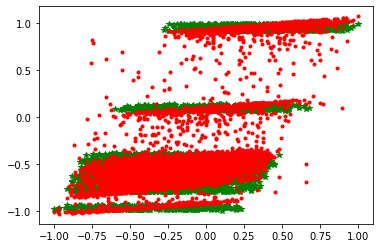

 Epoch 19 Loss:  0.002694944851100445


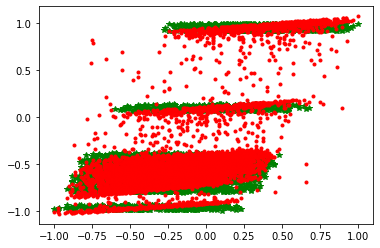

 Epoch 20 Loss:  0.0026875007897615433


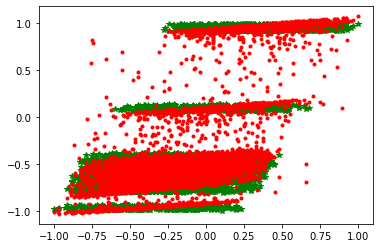

 Epoch 21 Loss:  0.0026807240210473537


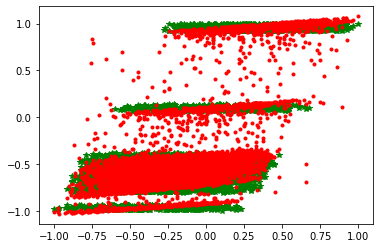

 Epoch 22 Loss:  0.002674640156328678


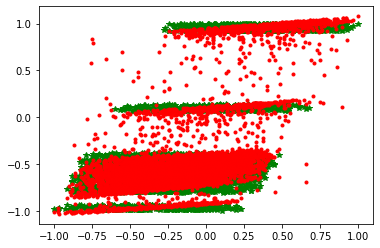

 Epoch 23 Loss:  0.0026692699175328016


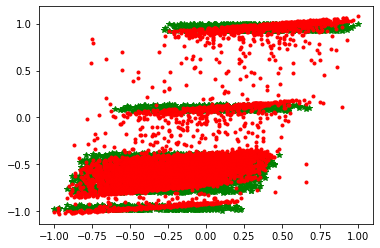

 Epoch 24 Loss:  0.002664591185748577


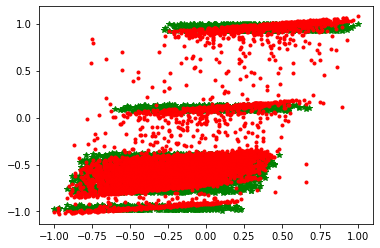

 Epoch 25 Loss:  0.002660605125129223


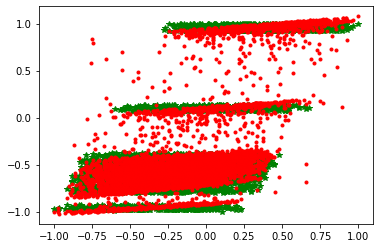

 Epoch 26 Loss:  0.0026572872884571552


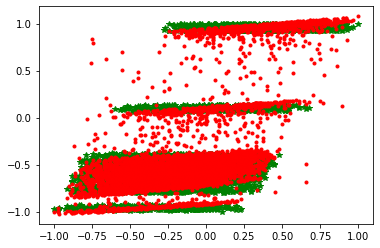

 Epoch 27 Loss:  0.0026546595618128777


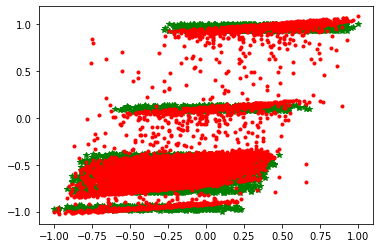

 Epoch 28 Loss:  0.0026526928413659334


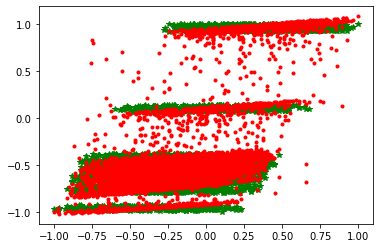

 Epoch 29 Loss:  0.002651374554261565


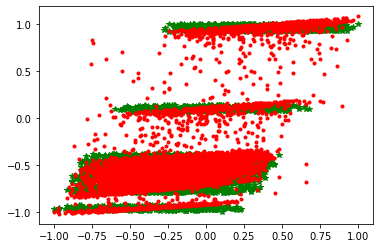

 Epoch 30 Loss:  0.0026507084257900715


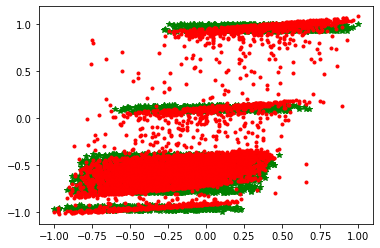

 Epoch 31 Loss:  0.002650644164532423


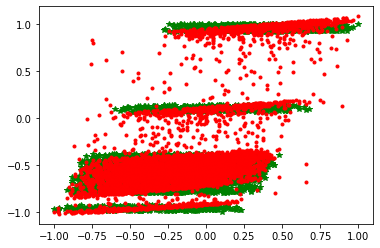

 Epoch 32 Loss:  0.0026511780451983213


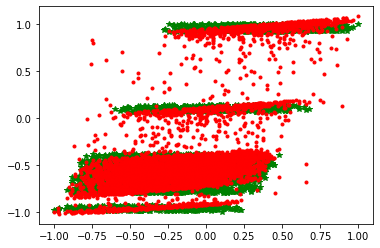

 Epoch 33 Loss:  0.0026523214764893055


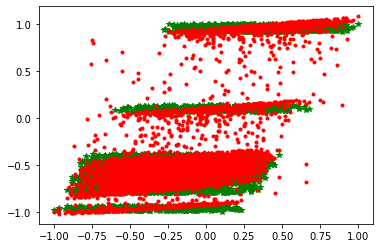

 Epoch 34 Loss:  0.0026540039107203484


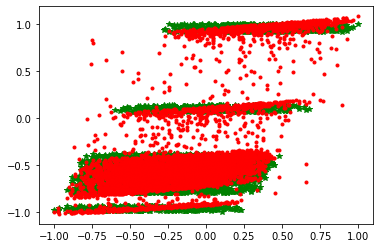

 Epoch 35 Loss:  0.0026562411803752184


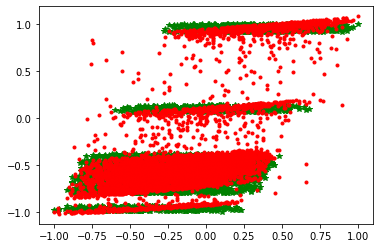

 Epoch 36 Loss:  0.0026590097695589066


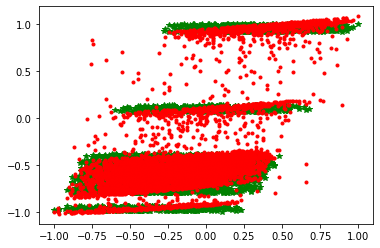

 Epoch 37 Loss:  0.0026622749865055084


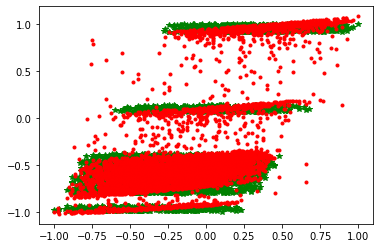

 Epoch 38 Loss:  0.0026660191360861063


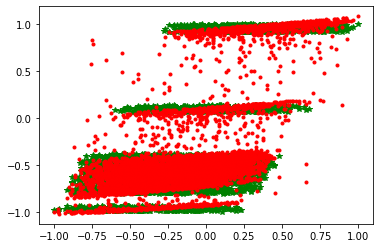

 Epoch 39 Loss:  0.0026702554896473885


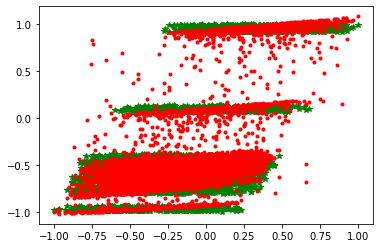

 Epoch 40 Loss:  0.002674920717254281


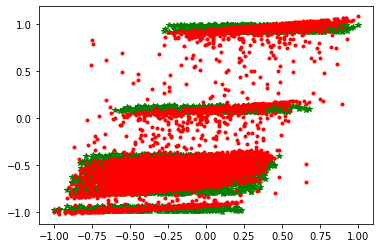

 Epoch 41 Loss:  0.0026800313498824835


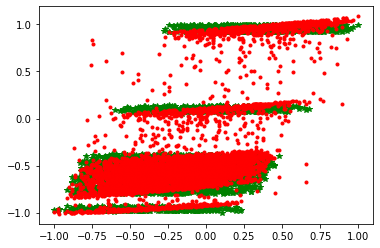

 Epoch 42 Loss:  0.002685548271983862


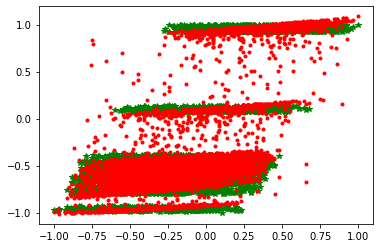

 Epoch 43 Loss:  0.0026914665941148996


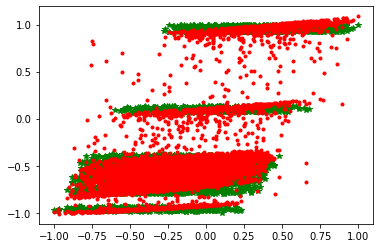

 Epoch 44 Loss:  0.0026977413799613714


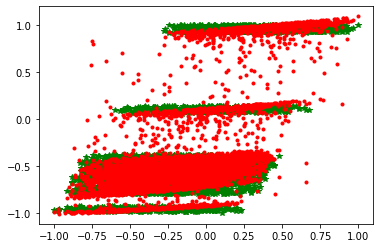

 Epoch 45 Loss:  0.002704413840547204


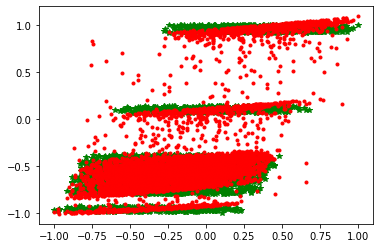

 Epoch 46 Loss:  0.0027114020194858313


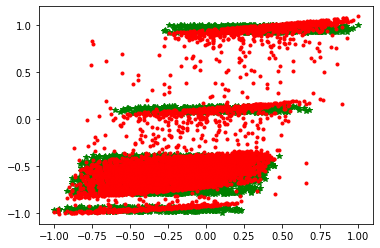

 Epoch 47 Loss:  0.002718722214922309


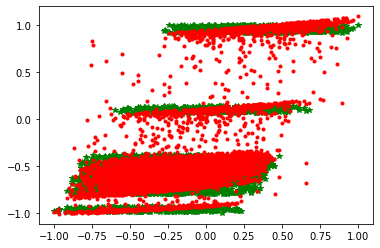

 Epoch 48 Loss:  0.0027263760566711426


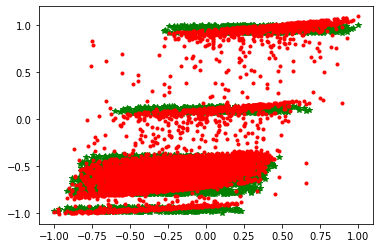

 Epoch 49 Loss:  0.002734302543103695


In [17]:
# 训练模型
epochs = 50
plt.plot(x_train_norm.cpu(),y_train_norm.cpu(),'g*')
plt.show()
for i in range(epochs):
    pltpred = []
    
    for seq, y_train in train_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1, model.hidden_size).cuda(), torch.zeros(1,1, model.hidden_size).cuda())
        y_pred = model(seq)
        pltpred.append(y_pred)

        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    
#     plt.plot(x,'.')
#     plt.show()
    plt.plot(x_train_norm.cpu(),y_train_norm.cpu(),'g*')
#     print(pltpred)
    plt.plot(x_train_norm.cpu(),pltpred,'r.')
    plt.show()

    print( f" Epoch {i} Loss:  {loss.item()}")

In [22]:
model.eval()
with torch.no_grad():
    model.hidden = (torch.zeros(1,1,model.hidden_size).cuda(),torch.zeros(1,1,model.hidden_size).cuda())
    print(model(torch.Tensor([]).cuda()).item())

1.8581299781799316
